## Assignment 7 
### Feature selection

In this assignment, the HTRU2 dataset is used that can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HTRU2).

In this workbook, feature selection techniques are implemented.
To minimize the work, all models that are trained in this workbook are XGBoost classifier. No other combinations of features/models are tested to find the best scoring one. Also, with every feature selection technique the dimensionality of the predictor variables is either reduced to half (4 features selected), or, when possible, we let the algorithm decide on the best number of features. Last, a model is trained will all features and the results are compared.  
No tuning on parameters is implemented. Every method is using the default parameters.

### Introduction
Introduction can be found on asgmt7_feat_importance_afoudouli.ipynb

In [1]:
# if needed install packages by uncommenting the following lines
#!pip install mlxtend
#!pip install xgboost
#!pip install Boruta
#!pip install yellobrick

In [2]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBClassifier
from boruta import BorutaPy
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
import os 

os.chdir('C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt7_FeatureSelection/')

In [3]:
data_file = 'HTRU2/HTRU_2.csv'

data = pd.read_csv(data_file, header=None)


feature_names = ["Mean of the integrated profile",
	"Standard deviation of the integrated profile",
	"Excess kurtosis of the integrated profile",
	"Skewness of the integrated profile",
	"Mean of the DM-SNR curve",
	"Standard deviation of the DM-SNR curve",
	"Excess kurtosis of the DM-SNR curve",
	"Skewness of the DM-SNR curve"]

data.columns = feature_names + ["target_class"]

In [4]:
# split in train-test set in a stratified manner
X = data.drop(columns = 'target_class')
y = data['target_class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=556, stratify=y)

** Feature Selection **  

As the name suggests, feature selection is the process of selecting the most _significant_ and_relevant_ features from a vast set of features in the given dataset. It is a crusial component in ML and data science workflows, especially when dealing with high-dimensional data.  
Feature selections helps finding the smallest set of features, thus resulting in: 
* training any ML algorithm faster
* reducing the complexity of a model, making it easier to interpret
* reducing over-fitting by selecting the right set of features

** Filter Method ** 
 
Statistical tests can be used to select those features that have the strongest relationship with the output variable.  
In this method, as the name suggests, we are filtering the dataset and select only a subset of the available features. The selection of features is independent of any machine learning algorithm. Features give rank on the basis of statistical scores which tend to determine the features' correlation with the outcome variable. Correlation is a heavily contextual term, and it varies from work to work.  

Example methods: Correlation coefficient scores (like Pearson's correlation), chi-squared test, information gain

In [6]:
scaler = MinMaxScaler()
chisq_selector = SelectKBest(score_func=chi2, 
                             k=4)
clf = XGBClassifier(n_jobs=-1)


chisq_pipe = Pipeline([('scaler', scaler),
                       ('selector', chisq_selector),
                       ('classifier', clf)])

chisq_pipe.fit(X_train, y_train)

print('Selected variables with chi-squared test are:')
print('\n'.join([x for x,y in zip(feature_names, chisq_pipe.named_steps['selector'].get_support()) if y]))

Selected variables with chi-squared test are:
Excess kurtosis of the integrated profile
Skewness of the integrated profile
Mean of the DM-SNR curve
Standard deviation of the DM-SNR curve


** Wrapper Methods ** 

In wrapper methods, the feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset.

These methods are called greedy algorithms, as they evaluate all the possible combinations of features against the evaluation criterion. The evaluation criterion is simply the performance measure which depends on the type of problem, for e.g. For regression evaluation criterion can be p-values, R-squared, Adjusted R-squared, similarly for classification the evaluation criterion can be accuracy, precision, recall, f1-score, etc. Finally, it selects the combination of features that gives the optimal results for the specified machine learning algorithm.

### Sequential Feature Selection
** Forward selection **

The procedure starts with an empty set of features (reduced set). The best of the original features is determined and added to the reduced set. At each subsequent iteration, the best of the remaining original attributes is added to the set.

In [7]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)
sfs_frwd_selector = SFS(clf,
                        k_features=4,
                        forward=True,
                        floating=False,
                        scoring='recall',
                        cv=5)

sfs_frwd_pipe = Pipeline([('scaler', scaler),
                          ('selector', sfs_frwd_selector),
                          ('classifier', clf)])

sfs_frwd_pipe.fit(X_train, y_train)

print('Selected variables using forward selection are:')
print('\n'.join([y for x,y in enumerate(feature_names) if x in sfs_frwd_pipe.named_steps['selector'].k_feature_idx_]))

Selected variables using forward selection are:
Standard deviation of the integrated profile
Excess kurtosis of the integrated profile
Mean of the DM-SNR curve
Standard deviation of the DM-SNR curve


** Backward Elimination **

This method works exactly opposite to the Forward Feature Selection method. Here, we start with all the features available and build a model. At each step, the worst attribute remaining in the set is removed.

In [8]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)
sfs_bcwd_selector = SFS(clf,
                        k_features=4,
                        forward=False,
                        floating=False,
                        scoring='recall',
                        cv=5)

sfs_bcwd_pipe = Pipeline([('scaler', scaler),
                          ('selector', sfs_bcwd_selector),
                          ('classifier', clf)])

sfs_bcwd_pipe.fit(X_train, y_train)

print('Selected variables using backward selection are:')
print('\n'.join([y for x,y in enumerate(feature_names) if x in sfs_bcwd_pipe.named_steps['selector'].k_feature_idx_]))

Selected variables using backward selection are:
Standard deviation of the integrated profile
Excess kurtosis of the integrated profile
Standard deviation of the DM-SNR curve
Excess kurtosis of the DM-SNR curve


_We can use the same python code to find the optimal number of features and not directly specifying to keep only 4. The resulting model performance is ploted._

In [9]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)
sfs_bcwd_opt_selector = SFS(clf,
                            k_features=(2,8),
                            forward=False,
                            floating=False,
                            scoring='recall',
                            cv=5)

sfs_bcwd_opt_pipe = Pipeline([('scaler', scaler),
                              ('selector', sfs_bcwd_opt_selector),
                              ('classifier', clf)])

sfs_bcwd_opt_pipe.fit(X_train, y_train)

print(f'The optimal number of variables using backward selection are {len(sfs_bcwd_opt_pipe.named_steps["selector"].k_feature_idx_)}. Selected features are:')
print('\n'.join([y for x,y in enumerate(feature_names) if x in sfs_bcwd_opt_pipe.named_steps['selector'].k_feature_idx_]))

The optimal number of variables using backward selection are 6. Selected features are:
Standard deviation of the integrated profile
Excess kurtosis of the integrated profile
Skewness of the integrated profile
Standard deviation of the DM-SNR curve
Excess kurtosis of the DM-SNR curve
Skewness of the DM-SNR curve


** Recursive feature elimination **

This method perform a greedy search to find the best performing feature subset. Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Found on the official [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_selection.html#rfe)

In [10]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)
rfe_selector = RFE(clf, 
                   n_features_to_select=4)

rfe_pipe = Pipeline([('scaler', scaler),
                     ('selector', rfe_selector),
                     ('classifier', clf)])

rfe_pipe.fit(X_train, y_train)

print('Selected features using RFE are:')
print('\n'.join([x for x,y in zip(feature_names, rfe_pipe.named_steps['selector'].get_support()) if y]))

Selected features using RFE are:
Excess kurtosis of the integrated profile
Mean of the DM-SNR curve
Standard deviation of the DM-SNR curve
Excess kurtosis of the DM-SNR curve


However, it is often not known in advance how many features are valid. To find the optimal number of features cross-validation is used with RFE to score different feature subsets and select the best scoring collection of features.

Great documentation on [Yellowbrick docs](https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html).

In [11]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)
rfecv_selector = RFECV(clf,
                       cv=5,
                       n_jobs=-1, 
                       scoring='recall')
rfecv_pipe = Pipeline([('scaler', scaler),
                       ('selector', rfecv_selector),
                       ('classifier', clf)])

rfecv_pipe.fit(X_train, y_train)

print(f'The optimal number of variables using RFECV are {rfecv_pipe.named_steps["selector"].get_support().sum()}. Selected features are:')
print('\n'.join([x for x,y in zip(feature_names, rfecv_pipe.named_steps['selector'].get_support()) if y]))

The optimal number of variables using RFECV are 6. Selected features are:
Standard deviation of the integrated profile
Excess kurtosis of the integrated profile
Mean of the DM-SNR curve
Standard deviation of the DM-SNR curve
Excess kurtosis of the DM-SNR curve
Skewness of the DM-SNR curve


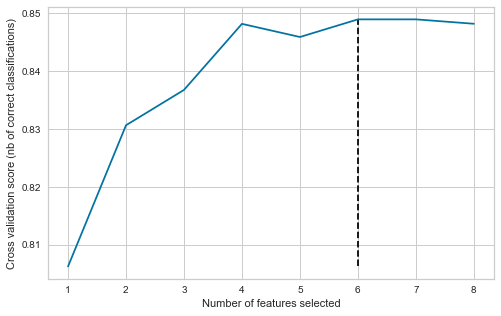

In [12]:
plt.figure(figsize=(8,5))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv_pipe.named_steps['selector'].grid_scores_) + 1), rfecv_pipe.named_steps['selector'].grid_scores_)
plt.vlines(x=np.where(rfecv_pipe.named_steps['selector'].grid_scores_==rfecv_pipe.named_steps['selector'].grid_scores_.max())[0]+1,
    ymin=rfecv_pipe.named_steps['selector'].grid_scores_.min(),
    ymax=rfecv_pipe.named_steps['selector'].grid_scores_.max(), 
    linestyles='--',
    color='black')

plt.show()

** Boruta **


Boruta is a smart algorithm for feature selection.  
In Boruta, features do not compete among themselves. Instead they compete with a randomized version of them. Starting from X, another table is created by randomly shuffling each feature. These permuted features are called **shadow features**. The table is then merged with the orginal dataset. Then a tree-based algorithm (like **random forest**) is fitted on the merged table and the target variable. The importance of each feature is calculated and compared with a **threshold**. Τhe threshold is defined as the highest feature importance recorded among the shadow features. When the importance of a feature is higher than this threshold, this is called a “hit”. The idea is that a feature is useful only if it’s capable of doing better than the best randomized feature. The same process is iterated multiple times. A criterion is also needed, to decide how many times a feature needs to appear as a hit. The maximum level of uncertainty about the feature is expressed by a probability of 50%, like tossing a coin. Since each independent experiment can give a binary outcome (hit or no hit), a series of n trials follows a binomial distribution. We can then use statistics to decide from the distribution. Depending on the number of appearances as hit variables, a variable may be **rejected**, **confirmed** or **tentative**.

Fun fact1: The algorithm started as an [R package](https://www.jstatsoft.org/article/view/v036i11)!   
Fun fact2: Took me 3 years to finaly run Boruta since first reading for the method. :(  
Fun fact3: You can add emojis on code (with emoji package) but not on Markdown!

Great documentation can be found on [GitHub](https://github.com/scikit-learn-contrib/boruta_py).

In [13]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)
boruta_selector = BorutaPy(clf, 
                           n_estimators='auto', 
                           random_state=234, 
                           #verbose=2
                           )
boruta_pipe = Pipeline([('scaler', scaler),
                         ('selector', boruta_selector),
                         ('classifier', clf)])

boruta_pipe.fit(X_train, y_train)

print(f'The optimal number of variables using Boruta algorithm are {boruta_pipe.named_steps["selector"].support_.sum()}. Selected features are:')
print('\n'.join([x for x,y in zip(feature_names, boruta_pipe.named_steps['selector'].support_) if y]))

The optimal number of variables using Boruta algorithm are 7. Selected features are:
Mean of the integrated profile
Standard deviation of the integrated profile
Excess kurtosis of the integrated profile
Mean of the DM-SNR curve
Standard deviation of the DM-SNR curve
Excess kurtosis of the DM-SNR curve
Skewness of the DM-SNR curve


In [17]:
selected_features = {'chisq_selection': chisq_pipe.named_steps['selector'].get_support(),
                     'fwrd_selection': [True if x in sfs_frwd_pipe.named_steps['selector'].k_feature_idx_ else False for x,y in enumerate(feature_names)],
                     'bwrd_selection': [True if x in sfs_bcwd_pipe.named_steps['selector'].k_feature_idx_ else False for x,y in enumerate(feature_names)],
                     'optimal_bcwd_selection': [True if x in sfs_bcwd_opt_pipe.named_steps['selector'].k_feature_idx_ else False for x,y in enumerate(feature_names)],
                     'rfe_selection': rfe_pipe.named_steps['selector'].get_support(),
                     'optimal_rfe_selection': rfecv_pipe.named_steps['selector'].get_support(),
                     'boruta_selection': boruta_pipe.named_steps['selector'].support_,
                    }
feat_df = pd.DataFrame(selected_features, index=feature_names)
feat_df['n_times_selected_prc'] = round(feat_df.sum(axis=1)/feat_df.shape[1], 2)
feat_df

,chisq_selection,fwrd_selection,bwrd_selection,optimal_bcwd_selection,rfe_selection,optimal_rfe_selection,boruta_selection,n_times_selected_prc
Mean of the integrated profile,False,False,False,False,False,False,True,0.14
Standard deviation of the integrated profile,False,True,True,True,False,True,True,0.71
Excess kurtosis of the integrated profile,True,True,True,True,True,True,True,1.00
Skewness of the integrated profile,True,False,False,True,False,False,False,0.29
Mean of the DM-SNR curve,True,True,False,False,True,True,True,0.71
Standard deviation of the DM-SNR curve,True,True,True,True,True,True,True,1.00
Excess kurtosis of the DM-SNR curve,False,False,True,True,True,True,True,0.71
Skewness of the DM-SNR curve,False,False,False,True,False,True,True,0.43


Another pipeline where no feature selection is done is trained.   
Following, are produce classification reports for all of the models.  
Generally all models have preformed similarly. Therefore, is would be advised to reduce the dimensions to 4, to reduce the complexity and the training times of the model, while still get similar recall, precision and F1 scores.

In [15]:
scaler = MinMaxScaler()
clf = XGBClassifier(n_jobs=-1)

no_selector_pipe = Pipeline([('scaler', scaler),
                             ('classifier', clf)])

no_selector_pipe.fit(X_train, y_train);

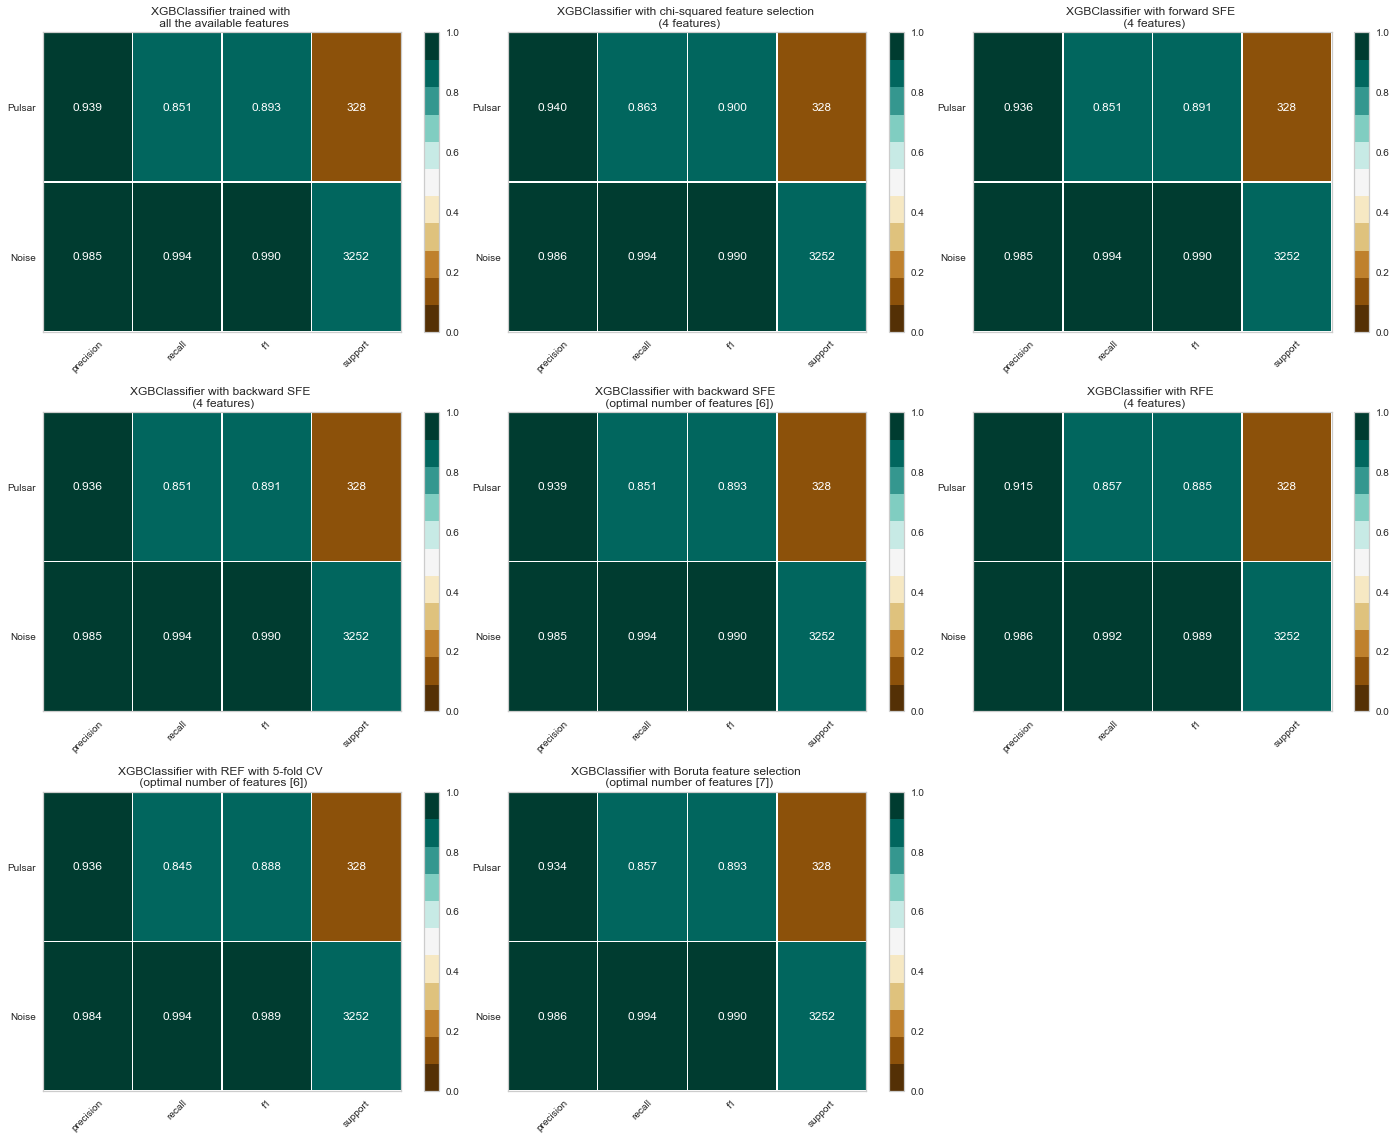

In [16]:
pipes = [no_selector_pipe,
         chisq_pipe,
         sfs_frwd_pipe,
         sfs_bcwd_pipe,
         sfs_bcwd_opt_pipe,
         rfe_pipe,
         rfecv_pipe,
         boruta_pipe,
         ]
titles = ['XGBClassifier trained with \n all the available features',
          'XGBClassifier with chi-squared feature selection \n (4 features)',
          'XGBClassifier with forward SFE \n (4 features)',
          'XGBClassifier with backward SFE \n (4 features)',
          f'XGBClassifier with backward SFE \n (optimal number of features [{len(sfs_bcwd_opt_pipe.named_steps["selector"].k_feature_idx_)}])',
          'XGBClassifier with RFE \n (4 features)',
          f'XGBClassifier with REF with 5-fold CV \n (optimal number of features [{rfecv_pipe.named_steps["selector"].get_support().sum()}])',
          f'XGBClassifier with Boruta feature selection \n (optimal number of features [{boruta_pipe.named_steps["selector"].support_.sum()}])',
          ]

plt.figure(figsize=(20,16))
for pipe, title, position in zip(pipes, titles, range(len(pipes))):
    ax=plt.subplot(3,3,position+1)
    visualizer = ClassificationReport(pipe, 
                                      classes=['Noise', 'Pulsar'],
                                      cmap='BrBG',
                                      support=True,
                                      title=title,
                                      ax=ax,
                                      )
    visualizer.score(X_test, y_test)
    visualizer.finalize()
plt.tight_layout()

**TODO** 
Feature selection algorithms for high dimensional detasets